In [1]:

import os
import csv
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sklearn
import timeit
import random

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.models import load_model
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.models import model_from_json
import json

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Using TensorFlow backend.


In [2]:
cwd = os.getcwd()

In [3]:
# read images log file 
lines = []

with open('data/driving_log.csv') as csvfle:
    reader = csv.reader(csvfle)
    for line in reader:
        lines.append(line)
print (len(lines))
header = lines[0]
del lines[0]

7247


In [4]:
data_dir = './data'
data_csv = '/driving_log.csv'
model_json = 'model_behavioral_cloning_augmentation.json'
model_weights = 'model_behavioral_cloning_augmentation.h5'

col_names = ['centre', 'left','right','steering_angle','throttle','brake','speed']
training_data = pd.read_csv('./data/driving_log.csv',names=col_names)
training_data.head()

,centre,left,right,steering_angle,throttle,brake,speed
0,/home/chu-chu/self_driving_car_nanodegree/CarN...,/home/chu-chu/self_driving_car_nanodegree/CarN...,/home/chu-chu/self_driving_car_nanodegree/CarN...,0.0,0.0,0,2.427794e-07
1,/home/chu-chu/self_driving_car_nanodegree/CarN...,/home/chu-chu/self_driving_car_nanodegree/CarN...,/home/chu-chu/self_driving_car_nanodegree/CarN...,0.0,0.0,0,6.757399e-07
2,/home/chu-chu/self_driving_car_nanodegree/CarN...,/home/chu-chu/self_driving_car_nanodegree/CarN...,/home/chu-chu/self_driving_car_nanodegree/CarN...,0.0,0.0,0,9.954655e-07
3,/home/chu-chu/self_driving_car_nanodegree/CarN...,/home/chu-chu/self_driving_car_nanodegree/CarN...,/home/chu-chu/self_driving_car_nanodegree/CarN...,0.0,0.0,0,1.387092e-06
4,/home/chu-chu/self_driving_car_nanodegree/CarN...,/home/chu-chu/self_driving_car_nanodegree/CarN...,/home/chu-chu/self_driving_car_nanodegree/CarN...,0.0,0.0,0,2.046672e-06


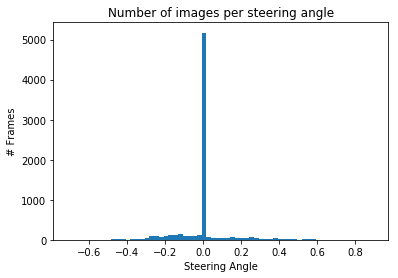

In [5]:
binwidth = 0.025
# histogram before image augmentation
plt.hist(training_data.steering_angle,bins=np.arange(min(training_data.steering_angle), max(training_data.steering_angle) + binwidth, binwidth))
plt.title('Number of images per steering angle')
plt.xlabel('Steering Angle')
plt.ylabel('# Frames')
plt.show()

In [6]:
training_data.centre[0]

'/home/chu-chu/self_driving_car_nanodegree/CarND-Behavioral-Cloning-P3/data/IMG/center_2018_01_04_22_43_01_150.jpg'

TypeError: unhashable type: 'numpy.ndarray'

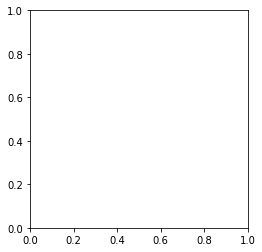

In [22]:
img = mpimg.imread(lines[3][0])
# print (lines[3][0])
# print(type(img))
# img = img.squeeze()
plt.imshow("",img)

In [7]:
# read images file (all 3 cameras), implement steering correction for the left and right camera
# NB: implementing steering corrections for the left and right camera allows to x3 augment the data set
images = []
measurements = []
correction = 0.25 # steering correction for the left and right camera

for line in lines:
    for i in range(3):
        source_path = line[i]
        filename = source_path.split('/')[-1]
        current_path = cwd + '/data/IMG/' + filename
        image = mpimg.imread(current_path)
        images.append(image)
    # implement steering correction for the left and right camera, save steering with corrections    
    steering_center = float(line[3])
    steering_left = steering_center + correction
    steering_right = steering_center - correction
    if steering_center< 0.1 and steering_center > -0.1 and random.randint(0,1) ==0:
        continue
    measurements.append(steering_left)
    measurements.append(steering_right)
    measurements.append(steering_center)

In [29]:
print (len(measurements))

13224


(array([   20.,   128.,   903.,  3614.,  3919.,  3700.,   543.,   302.,
           86.,     9.]),
 array([-0.957295  , -0.74929623, -0.54129746, -0.33329869, -0.12529992,
         0.08269885,  0.29069762,  0.49869639,  0.70669516,  0.91469393,
         1.1226927 ]),
 <a list of 10 Patch objects>)

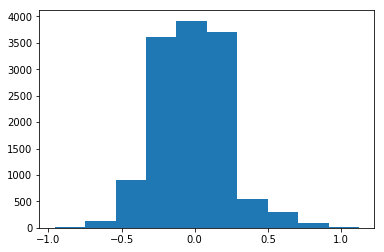

In [30]:
plt.hist(measurements)

In [5]:
len(images)

21738

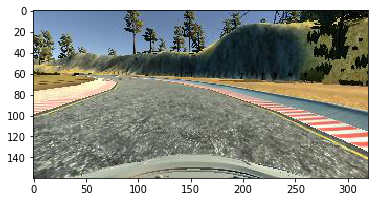

In [6]:
plt.imshow(images[0])

In [7]:
# flipping images and steering measurements (an effective technique for helping with the left turn bias)
augmented_images = []
augmetned_measurements = []
    
for image, measurement in zip(images, measurements):
    augmented_images.append(image)
    augmetned_measurements.append(measurement)
    augmented_images.append(cv2.flip(image,1))
    augmetned_measurements.append(measurement * -1)

In [8]:
X_train = np.array(augmented_images)
y_train = np.array(augmetned_measurements)

In [9]:
X_train.shape

(43476, 160, 320, 3)

In [10]:
samples = lines
ch, row, col = 3, 80, 320  # Trimmed image format
train_samples, validation_samples = train_test_split(samples, test_size=0.2)


In [11]:
# implement image generator - modification of baseline function from the lecture notes

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        samples = np.random.permutation(samples)
        #shuffle(samples)
        for offset in range(0, num_samples - batch_size, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                
                center_image = mpimg.imread(cwd + '/data/IMG/' +batch_sample[0].split('/')[-1])
                left_image = mpimg.imread(cwd + '/data/IMG/' +batch_sample[1].split('/')[-1])
                right_image = mpimg.imread(cwd + '/data/IMG/' +batch_sample[2].split('/')[-1])
                
                images.append(center_image)
                images.append(left_image)
                images.append(right_image)
                
                center_angle = float(batch_sample[3])
                left_angle = center_angle + correction
                right_angle = center_angle - correction
                
                angles.append(center_angle)
                angles.append(left_angle)
                angles.append(right_angle)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

In [12]:
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

In [14]:
# modified NVDIA architecture
model = Sequential()
model.add(Lambda(lambda x: (x/255.0) - 0.5, input_shape = (160, 320,3)))
model.add(Cropping2D(cropping = ((70,25),(0,0))))
model.add(Conv2D(24,(5,5), subsample = (2,2), activation = 'relu'))
model.add(Conv2D(36,(5,5), subsample = (2,2), activation = 'relu'))
model.add(Conv2D(48,(5,5), subsample = (2,2), activation = 'relu'))
model.add(Conv2D(64,(3,3), activation = 'relu'))
model.add(Conv2D(64,(3,3), activation = 'relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

In [15]:
start_time = timeit.default_timer()
model.compile(loss =  'mse', optimizer =  'adam')
mhistory_object =  model.fit(X_train, y_train, validation_split = 0.2, shuffle = True, nb_epoch = 5)
model.save('model_modified_NVDIA.h5')

elapsed = timeit.default_timer() - start_time
print('time to train modified NVDIA model: %.2f' % (elapsed))

Train on 34780 samples, validate on 8696 samples
Epoch 1/5
34780/34780 [==============================] - 76s - loss: 0.0294 - val_loss: 0.0304
Epoch 2/5
34780/34780 [==============================] - 19s - loss: 0.0227 - val_loss: 0.0321
Epoch 3/5
34780/34780 [==============================] - 18s - loss: 0.0211 - val_loss: 0.0314
Epoch 4/5
34780/34780 [==============================] - 18s - loss: 0.0198 - val_loss: 0.0292
Epoch 5/5
34780/34780 [==============================] - 18s - loss: 0.0187 - val_loss: 0.0269
time to train modified NVDIA model: 152.18


dict_keys(['val_loss', 'loss'])


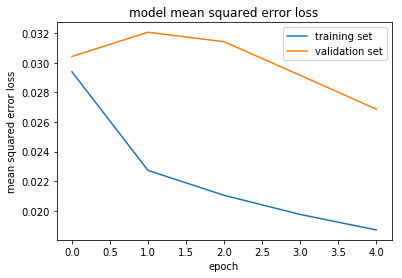

In [18]:
### print the keys contained in the history object
print(mhistory_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(mhistory_object.history['loss'])
plt.plot(mhistory_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [19]:
# train modified NVDIA model (using generator)
start_time = timeit.default_timer()
model.compile(loss='mse', optimizer='adam')
history_object = model.fit_generator(train_generator, samples_per_epoch= len(train_samples), validation_data=validation_generator, \
                    nb_val_samples=len(validation_samples), nb_epoch=4)
model.save('model_modified_NVDIA_generator.h5')
elapsed = timeit.default_timer() - start_time
print('time to train modified NVDIA model using generator: %.2f' % (elapsed))

Epoch 1/4
5796/5796 [==============================] - 701s - loss: 0.0081 - val_loss: 0.0182
Epoch 2/4
5796/5796 [==============================] - 714s - loss: 0.0030 - val_loss: 0.0181
Epoch 3/4
5796/5796 [==============================] - 712s - loss: 0.0024 - val_loss: 0.0188
Epoch 4/4
5796/5796 [==============================] - 700s - loss: 0.0021 - val_loss: 0.0180
time to train modified NVDIA model using generator: 2828.99


dict_keys(['val_loss', 'loss'])


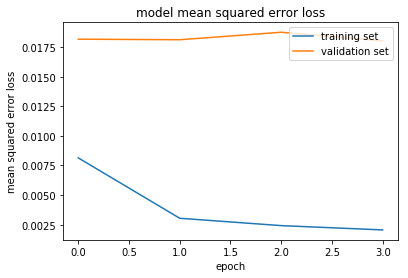

In [20]:
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()